In [1]:
!pip config set global.index-url https://mirrors.aliyun.com/pypi/simple/
!python -m pip install -U pip
!pip -V
!pip install sklearn pandas

Writing to /root/.config/pip/pip.conf
Looking in indexes: https://mirrors.aliyun.com/pypi/simple/
     |████████████████████████████████| 1.5 MB 10.5 MB/s eta 0:00:01
  Attempting uninstall: pip
    Found existing installation: pip 20.2.3
    Uninstalling pip-20.2.3:
      Successfully uninstalled pip-20.2.3
pip 20.2.4 from /usr/local/lib/python3.6/dist-packages/pip (python 3.6)
Looking in indexes: https://mirrors.aliyun.com/pypi/simple/
     |████████████████████████████████| 9.5 MB 333 kB/s eta 0:00:011
     |████████████████████████████████| 6.8 MB 1.7 MB/s eta 0:00:01
     |████████████████████████████████| 510 kB 399 kB/s eta 0:00:01
     |████████████████████████████████| 301 kB 4.8 MB/s eta 0:00:01
     |████████████████████████████████| 25.9 MB 149 kB/s eta 0:00:01
  Created wheel for sklearn: filename=sklearn-0.0-py2.py3-none-any.whl size=2397 sha256=e431dbddd6c9be2beed1209d42161e98a3118d2aa5d410c846f2aa8340abee24
  Stored in directory: /root/.cache/pip/wheels/b3/c8/54/ff7e171

In [2]:
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import sklearn
import sys
import tensorflow as tf
import time

from tensorflow import keras

print(tf.__version__)
print(sys.version_info)
for module in mpl, np, pd, sklearn, tf, keras:
    print(module.__name__, module.__version__)
    
print(tf.test.is_gpu_available())

2.3.1
sys.version_info(major=3, minor=6, micro=9, releaselevel='final', serial=0)
matplotlib 3.3.2
numpy 1.18.5
pandas 1.1.3
sklearn 0.23.2
tensorflow 2.3.1
tensorflow.keras 2.4.0
Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.
True


In [12]:
# download cifar10 from https://www.kaggle.com/c/cifar-10/data
class_names = [
    'airplane',
    'automobile',
    'bird',
    'cat',
    'deer',
    'dog',
    'frog',
    'horse',
    'ship',
    'truck',
]

train_lables_file = './cifar10/trainLabels.csv'
test_csv_file = './cifar10/sampleSubmission.csv'
train_folder = './cifar10/train'
test_folder = './cifar10/test'

def parse_csv_file(filepath, folder):
    '''Parses csv files into (filename(path), label) format'''
    results = []
    with open(filepath, 'r') as f:
        lines = f.readlines()[1:]
    for line in lines:
        image_id, label_str = line.strip('\n').split(',')
        image_full_path = os.path.join(folder, image_id + '.png')
        results.append((image_full_path, label_str))
    return results

train_labels_info = parse_csv_file(train_lables_file, train_folder)
test_csv_info = parse_csv_file(test_csv_file, test_folder)

from pprint import pprint
pprint(train_labels_info[:5])
pprint(test_csv_info[:5])
print(len(train_labels_info), len(test_csv_info))

[('./cifar10/train/1.png', 'frog'),
 ('./cifar10/train/2.png', 'truck'),
 ('./cifar10/train/3.png', 'truck'),
 ('./cifar10/train/4.png', 'deer'),
 ('./cifar10/train/5.png', 'automobile')]
[('./cifar10/test/1.png', 'cat'),
 ('./cifar10/test/2.png', 'cat'),
 ('./cifar10/test/3.png', 'cat'),
 ('./cifar10/test/4.png', 'cat'),
 ('./cifar10/test/5.png', 'cat')]
50000 300000


In [13]:
train_df = pd.DataFrame(train_labels_info[:45000])
valid_df = pd.DataFrame(train_labels_info[45000:])
test_df = pd.DataFrame(test_csv_info)

train_df.columns = ['filepath', 'class']
valid_df.columns = ['filepath', 'class']
test_df.columns = ['filepath', 'class']

print(train_df.head())
print(valid_df.head())
print(test_df.head())

                filepath       class
0  ./cifar10/train/1.png        frog
1  ./cifar10/train/2.png       truck
2  ./cifar10/train/3.png       truck
3  ./cifar10/train/4.png        deer
4  ./cifar10/train/5.png  automobile
                    filepath       class
0  ./cifar10/train/45001.png       horse
1  ./cifar10/train/45002.png  automobile
2  ./cifar10/train/45003.png        deer
3  ./cifar10/train/45004.png  automobile
4  ./cifar10/train/45005.png    airplane
               filepath class
0  ./cifar10/test/1.png   cat
1  ./cifar10/test/2.png   cat
2  ./cifar10/test/3.png   cat
3  ./cifar10/test/4.png   cat
4  ./cifar10/test/5.png   cat


In [15]:
height = 32
width = 32
channels = 3
batch_size = 32
num_classes = 10

train_datagen = keras.preprocessing.image.ImageDataGenerator(
    rescale = 1./255,
    rotation_range = 40,
    width_shift_range = 0.2,
    height_shift_range = 0.2,
    shear_range = 0.2,
    zoom_range = 0.2,
    horizontal_flip = True,
    fill_mode = 'nearest',
)

train_generator = train_datagen.flow_from_dataframe(
    train_df,
    directory = './',
    x_col = 'filepath',
    y_col = 'class',
    classes = class_names,
    target_size = (height, width),
    batch_size = batch_size,
    seed = 7,
    shuffle = True,
    class_mode = 'sparse'
)

valid_datagen = keras.preprocessing.image.ImageDataGenerator(
    rescale = 1./255,
)
valid_generator = valid_datagen.flow_from_dataframe(
    valid_df,
    directory = './',
    x_col = 'filepath',
    y_col = 'class',
    classes = class_names,
    target_size = (height, width),
    batch_size = batch_size,
    seed = 7,
    shuffle = False,
    class_mode = 'sparse'
)

train_num = train_generator.samples
valid_num = valid_generator.samples
print(train_num, valid_num)

Found 45000 validated image filenames belonging to 10 classes.
Found 5000 validated image filenames belonging to 10 classes.
45000 5000


In [16]:
for i in range(2):
    x, y = train_generator.next()
    print(x.shape, y.shape)
    print(y)

(32, 32, 32, 3) (32,)
[2. 1. 4. 4. 4. 4. 6. 5. 2. 8. 4. 6. 6. 3. 7. 1. 7. 2. 8. 8. 3. 0. 5. 3.
 9. 1. 4. 5. 6. 7. 9. 2.]
(32, 32, 32, 3) (32,)
[0. 7. 2. 7. 5. 5. 7. 0. 5. 4. 9. 7. 6. 3. 0. 4. 4. 4. 6. 3. 5. 4. 6. 6.
 4. 1. 8. 2. 4. 4. 3. 0.]


In [19]:
model = keras.models.Sequential([
    keras.layers.Conv2D(filters=128, kernel_size=3, padding='same', activation='selu', input_shape=[height, width, channels]),
    keras.layers.Conv2D(filters=128, kernel_size=3, padding='same', activation='selu'),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=2),
    keras.layers.Conv2D(filters=256, kernel_size=3, padding='same', activation='selu'),
    keras.layers.Conv2D(filters=256, kernel_size=3, padding='same', activation='selu'),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=2),
    keras.layers.Conv2D(filters=512, kernel_size=3, padding='same', activation='selu'),
    keras.layers.Conv2D(filters=512, kernel_size=3, padding='same', activation='selu'),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=2),
    keras.layers.Flatten(),
    keras.layers.Dense(512, activation='selu'),
    keras.layers.Dense(num_classes, activation='softmax'),
])
model.compile(loss='sparse_categorical_crossentropy',
             optimizer='adam',
             metrics=['accuracy'])

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 32, 32, 128)       3584      
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 32, 32, 128)       147584    
_________________________________________________________________
batch_normalization_3 (Batch (None, 32, 32, 128)       512       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 16, 16, 128)       0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 16, 16, 256)       295168    
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 16, 16, 256)       590080    
_________________________________________________________________
batch_normalization_4 (Batch (None, 16, 16, 256)      

In [20]:
epochs = 10
history = model.fit_generator(train_generator, 
                              steps_per_epoch = train_num // batch_size, 
                              epochs = epochs, 
                              validation_data = valid_generator,
                              validation_steps = valid_num // batch_size)

Epoch 1/10
1406/1406 [==============================] - 217s 154ms/step - loss: 2.1467 - accuracy: 0.3059 - val_loss: 1.5470 - val_accuracy: 0.4569
Epoch 2/10
1406/1406 [==============================] - 23s 16ms/step - loss: 1.6217 - accuracy: 0.4225 - val_loss: 1.5626 - val_accuracy: 0.4611
Epoch 3/10
1406/1406 [==============================] - 23s 16ms/step - loss: 1.4225 - accuracy: 0.4946 - val_loss: 1.2673 - val_accuracy: 0.5715
Epoch 4/10
1406/1406 [==============================] - 23s 16ms/step - loss: 1.2740 - accuracy: 0.5569 - val_loss: 1.3932 - val_accuracy: 0.5903
Epoch 5/10
1406/1406 [==============================] - 23s 16ms/step - loss: 1.1394 - accuracy: 0.6082 - val_loss: 1.3013 - val_accuracy: 0.5962
Epoch 6/10
1406/1406 [==============================] - 23s 16ms/step - loss: 1.0554 - accuracy: 0.6398 - val_loss: 0.9305 - val_accuracy: 0.6945
Epoch 7/10
1406/1406 [==============================] - 23s 16ms/step - loss: 0.9733 - accuracy: 0.6701 - val_loss: 0.8498

In [21]:
print(history.history.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


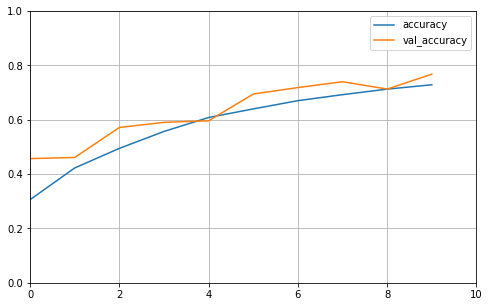

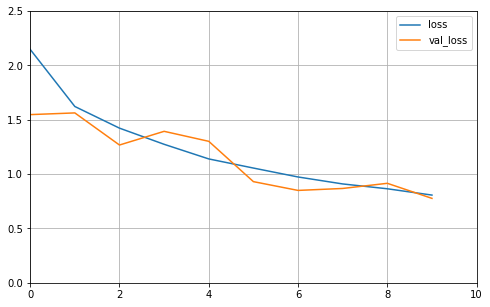

In [22]:
def plot_learning_curves(history, label, epochs, min_value, max_value):
    data = {}
    data[label] = history.history[label]
    data['val_'+label] = history.history['val_'+label]
    pd.DataFrame(data).plot(figsize=(8,5))
    plt.grid(True)
    plt.axis([0, epochs, min_value, max_value])
    plt.show()
    
plot_learning_curves(history, 'accuracy', epochs, 0, 1)
plot_learning_curves(history, 'loss', epochs, 0, 2.5)

In [23]:
test_datagen = keras.preprocessing.image.ImageDataGenerator(
    rescale = 1./255,
)
test_generator = valid_datagen.flow_from_dataframe(
    test_df,
    directory = './',
    x_col = 'filepath',
    y_col = 'class',
    classes = class_names,
    target_size = (height, width),
    batch_size = batch_size,
    seed = 7,
    shuffle = False,
    class_mode = 'sparse'
)
test_num = test_generator.samples
print(test_num)

Found 300000 validated image filenames belonging to 10 classes.
300000


In [24]:
test_predict = model.predict_generator(test_generator, workers = 10, use_multiprocessing = True)

Instructions for updating:
Please use Model.predict, which supports generators.


In [25]:
print(test_predict.shape)
print(test_predict[:5])

(300000, 10)
[[1.3586190e-02 3.0587788e-03 1.7455009e-01 5.9784506e-02 9.2325099e-02
  2.7341215e-02 5.4324329e-01 4.1298471e-02 9.2992093e-03 3.5513189e-02]
 [1.2991813e-01 1.7177983e-05 2.4056692e-01 2.0210589e-03 6.1829275e-01
  6.4311130e-04 4.0075975e-03 1.9194391e-03 2.2072475e-03 4.0661602e-04]
 [6.5383728e-07 9.0964651e-01 1.4811422e-07 9.8689434e-08 2.9311980e-08
  6.4156126e-08 4.7729513e-06 2.3960089e-08 1.8856363e-06 9.0345845e-02]
 [9.7196807e-06 6.9852234e-08 1.1976420e-07 5.6118482e-10 7.1981083e-09
  4.0599864e-11 3.2795210e-08 4.5415283e-10 9.9998212e-01 8.0438404e-06]
 [7.6401430e-01 1.4004410e-04 1.8166660e-01 4.3174257e-03 1.7569462e-02
  3.2023094e-03 1.3354266e-02 3.7080063e-03 8.7063359e-03 3.3212197e-03]]


In [26]:
test_predict_class_indices = np.argmax(test_predict, axis=1)

In [27]:
print(test_predict_class_indices[:5])

[6 4 1 8 0]


In [28]:
test_predict_class = [class_names[index]
                     for index in test_predict_class_indices]

In [32]:
def generate_submissions(filename, predict_class):
    with open(filename, 'w') as f:
        f.write('id,label\n')
        for i in range(len(predict_class)):
            f.write('%d,%s\n' % (i+1,predict_class[i]))
            
output_file = './cifar10/submission.csv'
generate_submissions(output_file, test_predict_class)